<a href="https://colab.research.google.com/github/PisanoRaffaele/MNLP_HM1.b/blob/main/LSTM_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#START

In [ ]:
import json
from pathlib import Path
from collections import Counter

import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab, vocab, Vectors
from torch.nn.utils.rnn import pack_padded_sequence
import torch.optim.lr_scheduler as lr_scheduler
import torchtext
from torchtext import data

import matplotlib.pyplot as plt

import random

import os

!pip install fasttext
import fasttext
import fasttext.util

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4227144 sha256=6de68d301fddc9967c845add3cb81b5f5d320fd4505303a1b556aaae22fae78e
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


## Data preparation

In [ ]:
!git clone https://github.com/PisanoRaffaele/MNLP_HM1.b

Cloning into 'MNLP_HM1.b'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (8/8), 571.23 KiB | 2.36 MiB/s, done.


In [ ]:
test_news_path = Path("MNLP_HM1.b/test-news-taskA.jsonl")
test_tweets_path = Path("MNLP_HM1.b/test-tweets-taskA.jsonl")
development_path = Path("MNLP_HM1.b/train-taskA.jsonl")
validation_path = Path("MNLP_HM1.b/validation.jsonl")
train_path = Path("MNLP_HM1.b/train.jsonl")

model_path = "/content/drive/MyDrive/MNLP_HM1.b/cc.it.300.bin"

### Creation of validation set

In [ ]:
seed = 1
random.seed(seed)

with open(development_path, "r", encoding="utf-8") as file:
    dev_data = [json.loads(line.strip()) for line in file]

shuffled_data = random.sample(dev_data, len(dev_data))
len_val = int(len(shuffled_data) * 0.2)

with open(validation_path, "w", encoding="utf-8") as file:
    for item in shuffled_data[:len_val]:
        file.write(json.dumps(item) + "\n")

with open(train_path, "w", encoding="utf-8") as file:
    for item in shuffled_data[len_val:]:
        file.write(json.dumps(item) + "\n")

In [ ]:
def visualize_hate_text(dataset: str, title: str):
    counter = Counter()

    with open(dataset) as f:
        for line in f:
            sample = json.loads(line.strip())
            if (sample['label'] == 0):
              counter[0] += 1
            else:
              counter[1] += 1

    l = sorted(counter)
    values = [counter[i] for i in l]

    plt.bar(l, values)
    plt.title(title)
    plt.show()

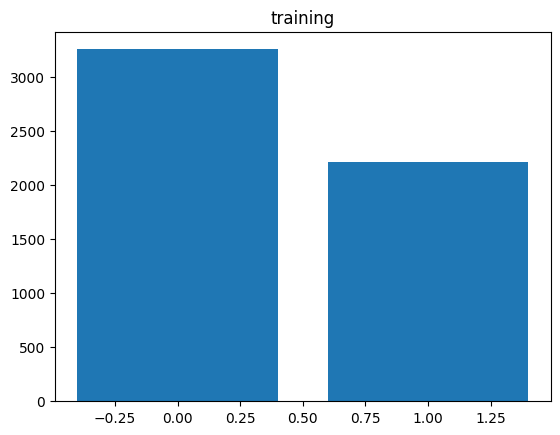

In [ ]:
visualize_hate_text(train_path, 'training')

In [ ]:
visualize_hate_text(validation_path, 'validation')

In [ ]:
visualize_hate_text(test_news_path, 'news')

In [ ]:
visualize_hate_text(test_tweets_path, 'tweets')

In [ ]:
#to save results on drive
from google.colab import drive
drive.mount('/content/drive')
model = fasttext.load_model(model_path)

Mounted at /content/drive


In [ ]:
embedded_words_list = model.get_words()

In [ ]:
embedded_words = {}
for i, elem in enumerate(embedded_words_list):
    embedded_words[elem] = i

##Dataset

I've noticed that, after the tokenization with the spacy italian tokenizer, a lot of the strings that haven't a corresponding word embedding in the fasttext model are strings not well tokenized:
- they starts or end with ' ( '; ' ) ' char;
- they have symbols between two or more words like:
  - "   
  - _
  - !
  - -
  - ?
  - ’
  - '

- There were a lot of words separated by a dot like:
 - cosa.che
 - .intolleranti
 - zingari.non


And there were a some 'common' words not finded in the embeddings that

I've have decided to modify the tokenizer s.t after the first tokenization i deal with the problems above with the custom tokenizer.

In [ ]:
#all this stuff is applied after the tokenization by the spacy tokenizer and it is a lot based on the output of the words do not tokenized.

def splitchar(token, char):
    ret = []
    splitted = token.split(char)
    i = 0
    for sub_token in splitted:
        if sub_token:
            ret.extend(checkToken(sub_token))
        if i != len(splitted) - 1:
            ret.append(char)
        i += 1
    return ret

def checkdots(token):
    pos_first = token.find('.')
    if token == '.':
        return [token]
    if len(token) > pos_first + 1 != None and token[pos_first + 1] == '.':
        return [token]
    if pos_first > 0 and len(token) > pos_first + 1:
        if token[pos_first - 1].isdigit() and token[pos_first + 1].isdigit():
            return [token]
    if len(token) > pos_first + 2 and token[pos_first + 2] == '.': #case like S.O.S. and all acronyms -> do not want to split them
        return [token]

    ret = []
    splitted = token.split('.', 1)
    i = 0
    for sub_token in splitted:
        if sub_token:
            ret.extend(checkToken(sub_token))
        if i != len(splitted) - 1:
            ret.append('.')
        i += 1
    return ret

def checkToken(token):
  new_tokens = []
  if '"' in token:
      new_tokens.extend(splitchar(token, '"'))
  elif ')' in token:
      new_tokens.extend(splitchar(token, ')'))
  elif '(' in token:
      new_tokens.extend(splitchar(token, '('))
  elif '-' in token:
      new_tokens.extend(splitchar(token, '-'))
  elif '_' in token:
      new_tokens.extend(splitchar(token, '_'))
  elif '!' in token:
      new_tokens.extend(splitchar(token, '!'))
  elif '?' in token:
      new_tokens.extend(splitchar(token, '?'))
  elif "'" in token:
      new_tokens.extend(splitchar(token, "'"))
  elif '’' in token:
      new_tokens.extend(splitchar(token, '’'))
  elif '”' in token:
      new_tokens.extend(splitchar(token, '”'))
  elif '\\' in token:
      new_tokens.extend(splitchar(token, '\\'))
  elif '/' in token:
      new_tokens.extend(splitchar(token, '/'))
  elif '•' in token:
      new_tokens.extend(splitchar(token, '•'))
  elif ',' in token:
      new_tokens.extend(splitchar(token, ','))
  elif '#' in token:
      new_tokens.extend(splitchar(token, '#'))
  elif '.' in token:
      new_tokens.extend(checkdots(token))
  else:
      new_tokens.append(token)
  return new_tokens


def custom_tokenizer(text, tokenizer):
    tokens = tokenizer(text)
    final_tokens = []

    for token in tokens:
        if token in embedded_words or token.lower() in embedded_words:
            final_tokens.append(token)
        else:
          final_tokens.extend(checkToken(token))
    return final_tokens

In [ ]:
#tests

!python -m spacy download it_core_news_sm
# tokenizer = get_tokenizer("spacy", language='it')
# print(custom_tokenizer("(few)))wef)\")) )ervre) ))", tokenizer))
# print(custom_tokenizer("?!No", tokenizer))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 22.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
class SST2Dataset(Dataset):
    def __init__(
        self,
        input_file: Path,
        max_length: int = 128,
        device: str = "cuda"
    ):
        tokenizer = get_tokenizer("spacy", language='it_core_news_sm')

        self.samples = []
        with open(input_file, "r") as f:
            for line in f:
                sample = json.loads(line.strip())
                sample["tokens"] = custom_tokenizer(sample["text"], tokenizer)
                self.samples.append(sample)

        self.indexed_data: list[dict] | None = None

        # Keep track of the maximum length to allow for a batch
        self.max_length = max_length

        # Save device
        self.device = torch.device(device)

        # The variable padding_id is used to keep track of the numeric ID used for the padding token within the vocabulary
        self.padding_id: int | None = None

    #returns the dict cooresponding to the sentence in position idx
    def get_raw_element(self, idx: int) -> dict:
        return self.samples[idx]

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> dict:
        if self.indexed_data is None:
            raise RuntimeError(
                "Trying to retrieve samples but dataset has not been indexed yet!"
                + " Be sure to call `.index()` on this object."
                + " If you want to retrieve raw elements, call `.get_raw_elements(idx)"
            )
        return self.indexed_data[idx]

    def get_vocabulary(
        self,
        pad_token: str = "<pad>",
        unk_token: str = "<unk>",
        extra_tokens: list[str] = []
    ) -> Vocab:
        # most_common() returns a list of (token, count) pairs, so we convert them back into dictionary
        # counts how many times a token appears in the dataset
        vocab_counter = dict(Counter(token for sample in self.samples for token in sample["tokens"]).most_common())

        # We build the vocabulary
        vocabulary = vocab(vocab_counter, min_freq=1, specials=[pad_token, unk_token, *extra_tokens])

        # the default index is the ID used when you have a token not present in the vocab.
        vocabulary.set_default_index(vocabulary([unk_token])[0])

        return vocabulary

    def set_padding_id(self, value: int) -> None:
        self.padding_id = value

    def index(self, vocab: dict[str, torch.Tensor]) -> None:
        if self.indexed_data is not None:
            print("Dataset has already been indexed. Keeping old index...")
        else:
            indexed_data = []
            for sample in self.samples:
                # append the dictionary containing ids of the input tokens and label
                indexed_data.append({"input_ids": vocabulary(sample["tokens"]), "label": sample["label"]})
            self.indexed_data = indexed_data

    def _collate_fn(self, raw_batch: list[dict]) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

        if self.padding_id is None:
            raise RuntimeError("Padding value not set! Set it through .set_padding_id method.")

        # We need these sequence lengths to construct a `torch.nn.utils.rnn.PackedSequence` in the model
        sequence_lengths = torch.tensor([len(sample["input_ids"]) for sample in raw_batch], dtype=torch.long)
        padded_sequence = pad_sequence(
            (
                torch.tensor(sample["input_ids"], dtype=torch.long, device=self.device)
                for sample in raw_batch
            ),
            batch_first=True,
            padding_value=self.padding_id
        )
        labels = torch.tensor([sample["label"] for sample in raw_batch], device=self.device, dtype=torch.long)
        return sequence_lengths, padded_sequence, labels

##Model

In [ ]:
class BiLSTMModel(torch.nn.Module):

    def __init__(
        self,
        vocabulary_length: int,
        hidden_dim: int,
        bilstm_layers: int,
        bilstm_dropout: float,
        num_classes: int,
        padding_id: int,
        device: str = "cuda",
        pre_embeddings: torch.Tensor = None,
    ) -> None:
        super().__init__()

        self.device = torch.device(device)

        self.embedding = nn.Embedding(
            num_embeddings=vocabulary_length,
            embedding_dim=hidden_dim,
            padding_idx=padding_id, # avoid updating the gradient of padding entries
            device=self.device
        )
        if pre_embeddings is not None:
            print("initializing embeddings from pretrained")
            self.embedding.weight.data.copy_(pre_embeddings)

        self.bilstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=bilstm_layers,
            batch_first=True,
            dropout=bilstm_dropout,
            bidirectional=True,
            device=self.device
        )

        self.projection = nn.Linear(
            in_features=hidden_dim * 2,
            out_features=num_classes,
            device=device
        )

    def forward(self, batch: tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        # Get the different parts of the batch
        sequence_lengths, input_ids = batch

        # First we embed the input tokens
        embeds = self.embedding(input_ids) # [B, S, H]
        # where B is the batch size, S is the sequence length and H is the hidden dimension

        # Pack the sequence to avoid gradient descent on padding tokens.
        # An alternative to packing sequences is using masking.
        packed = pack_padded_sequence(embeds, sequence_lengths, batch_first=True, enforce_sorted=False)

        # Then we pass it to the BiLSTM
        # The first output of the BiLSTM tuple, packed_output, is of size B x S x 2H,
        # where B is the batch size, S is the sequence length and H is the hidden dimension
        # hidden_state is of size [2 * num_layers, B, H], where the 2 is because we are using BiLSTMs instead of LSTMs.
        # cell_state has size [2 * num_layers, B, C] where C is the cell dimension of the internal LSTMCell.
        packed_output, (hidden_state, cell_state) = self.bilstm(packed)

        # We take the last two hidden representations of the BiLSTM (the second-to-last layer's output is forward; last
        # layer's is backward) by concatenating forward and backward over dimension 1.
        # Both tensors have shapes of [B, H], so concatenating them along the second dimension (dim 1) results in a new
        # tensor of shape [B, 2 * H]
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)

        # Finally we project to the two final classes and return the logits of each class
        # logits = values assigned to each class
        logits = self.projection(hidden) # [B, 2]
        return logits

## Trainer


In [ ]:
class Trainer():
    """Utility class to train and evaluate a model."""

    def __init__(
        self,
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        log_steps: int = 1_000,
        log_level: int = 2
    ):
        self.model = model
        self.optimizer = optimizer
        self.loss_function = nn.CrossEntropyLoss() # this is the default loss used nearly everywhere in NLP


        self.scheduler = None

        self.log_steps = log_steps
        self.log_level = log_level

    def set_scheduler(self, lr_decay_factor: float):
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=lr_decay_factor)

    def train(
        self,
        train_dataloader: DataLoader,
        valid_dataloader: DataLoader,
        epochs: int = 1,
        patience: int = 2,
        lr_decay_factor: float = 0.001
    ) -> dict[str, list[float]]:
        """
        Args:
            train_dataloader: a DataLoader instance containing the training instances.
            valid_dataloader: a DataLoader instance used to evaluate learning progress.
            epochs: the number of times to iterate over train_dataset.

        Returns:
            avg_train_loss: the average training loss on train_dataset over epochs.
        """
        assert epochs >= 1 and isinstance(epochs, int)
        if self.log_level > 0:
            print('Training ...')
        train_loss = 0.0

        losses = {
            "train_losses": [],
            "valid_losses": [],
            "valid_acc": [],
        }

        consecutive_increases = 0
        prev_valid_loss = float('inf')

        if self.scheduler is None:
            self.set_scheduler(lr_decay_factor)

        done = False

        for epoch in range(1, epochs + 1):
            if self.log_level > 0:
                print(' Epoch {:2d}'.format(epoch))

            epoch_loss = 0.0
            self.model.train()

            # for each batch
            for step, (sequence_lengths, inputs, labels) in enumerate(train_dataloader):
                # we need to set the gradients to zero before starting to do backpropragation
                # because PyTorch accumulates the gradients on subsequent backward passes
                self.optimizer.zero_grad()

                # We get the predicted logits from the model, with no need to perform any flattening
                # as both predictions and labels refer to the whole sentence.
                predictions = self.model((sequence_lengths, inputs))

                # The CrossEntropyLoss expects the predictions to be logits, i.e. non-softmaxed scores across
                # the number of classes, and the labels to be a simple tensor of labels.
                # Specifically, predictions needs to be of shape [B, C], where B is the batch size and C is the number of
                # classes, while labels must be of shape [B] where each element l_i should 0 <= l_i < C.
                # See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html for more information.
                sample_loss = self.loss_function(predictions, labels)
                sample_loss.backward()
                self.optimizer.step()

                epoch_loss += sample_loss.cpu().tolist()

                if self.log_level > 1 and (step % self.log_steps) == (self.log_steps - 1):
                    print('\t[E: {:2d} @ step {}] current avg loss = {:0.4f}'.format(epoch, step, epoch_loss / (step + 1)))

            avg_epoch_loss = epoch_loss / len(train_dataloader)

            if self.log_level > 0:
                print('\t[E: {:2d}] train loss = {:0.4f}'.format(epoch, avg_epoch_loss))

            valid_loss, valid_acc = self.evaluate(valid_dataloader)

            losses["train_losses"].append(avg_epoch_loss)
            losses["valid_losses"].append(valid_loss)
            losses["valid_acc"].append(valid_acc)

            if self.log_level > 0:
                print('  [E: {:2d}] valid loss = {:0.4f}, valid acc = {:0.4f}'.format(epoch, valid_loss, valid_acc))

            if valid_loss < 0.485 and done == False:
                done = True
                for param_group in self.optimizer.param_groups:
                    self.scheduler.step()
                if self.log_level > 0:
                    print('Reducing LR')

            # *********** if the val loss is decreasing for patience-times -> early stop *********** #
            if valid_loss > prev_valid_loss:
                consecutive_increases += 1
                if self.log_level > 0:
                  print('   Consecutive increases: ' + str(consecutive_increases))
            else:
                consecutive_increases = 0

            if consecutive_increases >= patience:
                if self.log_level > 0:
                    print('early stopping')
                break

            if consecutive_increases == 0:
                prev_valid_loss = valid_loss
            # *********** #

        if self.log_level > 0:
            print('... Done!')

        return losses


    def _compute_acc(self, logits: torch.Tensor, labels: torch.Tensor) -> float:
        # logits [B, 2] are the logits outputted by the BiLSTM model's forward()
        # We take the argmax along the second dimension (dim=1), so we get a tensor of shape [B]
        # where each element is 0 if the 0-class had higher logit, 1 otherwise.
        predictions = torch.argmax(logits, dim=1)
        # We can then directly compare each prediction with the labels, as they are both tensors with shape [B].
        # The average of the boolean equality checks between the two is the accuracy of these predictions.
        # For example, if:
        #   predictions = [1, 0, 0, 1, 1]
        #   labels = [1, 0, 1, 1, 1]
        # The comparison is:
        #   (predictions == labels) => [1, 1, 0, 1, 1]
        # which averaged gives an accuracy of 4/5, i.e. 0.80.
        return torch.mean((predictions == labels).float()).tolist() # type: ignore

    def evaluate(self, valid_dataloader: DataLoader) -> tuple[float, float]:
        """
        Args:
            valid_dataloader: the DataLoader to use to evaluate the model.

        Returns:
            avg_valid_loss: the average validation loss over valid_dataloader.
        """
        valid_loss = 0.0
        valid_acc = 0.0
        # When running in inference mode, it is required to have model.eval() AND .no_grad()
        # Among other things, these set dropout to 0 and turn off gradient computation.
        self.model.eval()
        with torch.no_grad():
            for batch in valid_dataloader:
                sequence_lengths, inputs, labels = batch

                logits = self.model((sequence_lengths, inputs))

                # Same considerations as the training step apply here
                sample_loss = self.loss_function(logits, labels)
                valid_loss += sample_loss.tolist()

                sample_acc = self._compute_acc(logits, labels)
                valid_acc += sample_acc

        return valid_loss / len(valid_dataloader), valid_acc / len(valid_dataloader),

    def predict(self, batch: tuple[torch.Tensor, torch.Tensor]) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            x: a tensor of indices
        Returns:
            A tuple composed of:
            - the logits of each class, 0 and 1
            - the prediction for each sample in the batch
              0 if the sentiment of the sentence is negative, 1 if it is positive.
        """
        self.model.eval()
        with torch.no_grad():
            sequence_lengths, inputs = batch
            logits = self.model(sequence_lengths, inputs) # [B, 2]
            predictions = torch.argmax(logits, -1) # [B, 1] computed on the last dimension of the logits tensor
            return logits, predictions

## Training

In [ ]:
pad_token, unk_token = "<pad>", "<unk>"
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)

train_dataset = SST2Dataset(train_path, device=device)
validation_dataset = SST2Dataset(validation_path, device=device)
test_tweets_dataset = SST2Dataset(test_tweets_path, device=device)
test_news_dataset = SST2Dataset(test_news_path, device=device)

vocabulary = train_dataset.get_vocabulary(pad_token=pad_token, unk_token=unk_token)
padding_id = vocabulary([pad_token])[0]

train_dataset.set_padding_id(padding_id)
validation_dataset.set_padding_id(padding_id)
test_tweets_dataset.set_padding_id(padding_id)
test_news_dataset.set_padding_id(padding_id)

train_dataset.index(vocabulary)
validation_dataset.index(vocabulary)
test_tweets_dataset.index(vocabulary)
test_news_dataset.index(vocabulary)

print(f"Training len: {len(train_dataset)}")
print(f"Validation len: {len(validation_dataset)}")
print(f"Test tweets len: {len(test_tweets_dataset)}")
print(f"Test news len: {len(test_news_dataset)}")

Training len: 5472
Validation len: 1367
Test tweets len: 1263
Test news len: 500


In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)

missing_file = "missing_words.txt"
founded_file = "founded_words.txt"

with open(missing_file, "w") as miss:
  with open(founded_file, "w") as find:
    pretrained_embeddings = torch.randn(len(vocabulary), 300)
    initialised = 0
    for i, w in enumerate(vocabulary.get_itos()):
        word_low = w.lower()
        if w in embedded_words:
            initialised += 1
            pretrained_embeddings[i] = torch.from_numpy(model.get_word_vector(w)).float()
            find.write(w + "\n")
        elif word_low in embedded_words:
            initialised += 1
            pretrained_embeddings[i] = torch.from_numpy(model.get_word_vector(word_low)).float()
            find.write(w + " -> " + word_low + "\n")
        else:
            miss.write(w + "\n")

pretrained_embeddings[vocabulary["<pad>"]] = torch.zeros(300)
print("initialised embeddings {}".format(initialised))
print("random initialised embeddings {} ".format(len(vocabulary) - initialised))

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)

results = {}
custom_epochs= 60
custom_hidden_dim = 300
custom_patience = 3
custom_batch_size = 32
custom_bilstm_layers = 3
custom_bilstm_dropout = 0.2
custom_lr = 5e-5

training_dataloader = DataLoader(train_dataset, batch_size=custom_batch_size, shuffle=True, collate_fn=train_dataset._collate_fn)
validation_dataloader = DataLoader(validation_dataset, batch_size=custom_batch_size, shuffle=False, collate_fn=validation_dataset._collate_fn)
test_news_dataloader = DataLoader(test_news_dataset, batch_size=custom_batch_size, shuffle=False, collate_fn=test_news_dataset._collate_fn)
test_tweets_dataloader = DataLoader(test_tweets_dataset, batch_size=custom_batch_size, shuffle=False, collate_fn=test_tweets_dataset._collate_fn)

while(True):

  sentiment_tagger = BiLSTMModel(
      vocabulary_length=len(vocabulary),
      hidden_dim=custom_hidden_dim,
      bilstm_layers=custom_bilstm_layers,
      bilstm_dropout=custom_bilstm_dropout,
      num_classes=2,
      padding_id=padding_id,
      device=device,
      pre_embeddings=pretrained_embeddings
  )

  trainer = Trainer(
      model=sentiment_tagger,
      optimizer=torch.optim.Adam(sentiment_tagger.parameters(), lr=custom_lr),
      log_steps=100,
      log_level=1
  )

  losses = trainer.train(training_dataloader, validation_dataloader, epochs=custom_epochs, patience=custom_patience)
  test_news_loss, test_news_acc = trainer.evaluate(test_news_dataloader)
  test_tweets_loss, test_tweets_acc = trainer.evaluate(test_tweets_dataloader)
  params = (custom_batch_size, custom_hidden_dim, custom_bilstm_layers, custom_bilstm_dropout, custom_lr)
  results[params] = {
      'train_losses': losses['train_losses'],
      'valid_losses': losses['valid_losses'],
      'valid_acc': losses['valid_acc'],
      'test_news_loss': test_news_loss,
      'test_news_acc': test_news_acc,
      'test_tweets_loss': test_tweets_loss,
      'test_tweets_acc': test_tweets_acc
  }

  print(params)
  print("valid_acc: " + str(losses['valid_acc'][len(losses['valid_acc']) - 1]))
  print("loss: " + str(losses['valid_losses'][len(losses['valid_losses']) - 1]))
  print("test_news_acc: " + str(test_news_acc))
  print("test_tweets_acc: " + str(test_tweets_acc))

  print()

  check = losses['valid_losses'][len(losses['valid_losses']) - 1]
  if check < 0.48:
    break

initializing embeddings from pretrained
Training ...
 Epoch  1


In [ ]:
train_losses = results[params]['train_losses']
valid_losses = results[params]['valid_losses']
valid_acc = results[params]['valid_acc']

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()